<a href="https://colab.research.google.com/github/hy96161/Human-Activity-Pattern-Mining/blob/main/GEOG6592_Lab3_Hao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# 1. Precipitation Time Series Exploration and Visualization

In [16]:
filepath = "/content/HW_precipitation_1939_2024.csv"

df = pd.read_csv(filepath, skiprows=[0,1,2,3])

In [17]:
df

,Date,Value,Anomaly
0,194006,0.57,0.07
1,194007,0.69,0.18
2,194008,0.42,-0.42
3,194009,0.46,-0.37
4,194010,1.53,0.02
...,...,...,...
1000,202310,0.58,-0.93
1001,202311,2.15,-0.10
1002,202312,0.89,-1.27
1003,202401,2.65,0.83


In [18]:
df["Date"].dtype

dtype('int64')

In [19]:
import datetime

df["Date"] = df['Date'].astype(str)
def convert_to_datetime(date_str):
    return datetime.datetime.strptime(date_str, "%Y%m")

df['DateTime'] = df['Date'].apply(convert_to_datetime)

# Display the DataFrame with the updated "Date" column
print(df)

        Date  Value  Anomaly   DateTime
0     194006   0.57     0.07 1940-06-01
1     194007   0.69     0.18 1940-07-01
2     194008   0.42    -0.42 1940-08-01
3     194009   0.46    -0.37 1940-09-01
4     194010   1.53     0.02 1940-10-01
...      ...    ...      ...        ...
1000  202310   0.58    -0.93 2023-10-01
1001  202311   2.15    -0.10 2023-11-01
1002  202312   0.89    -1.27 2023-12-01
1003  202401   2.65     0.83 2024-01-01
1004  202402   0.16    -1.78 2024-02-01

[1005 rows x 4 columns]


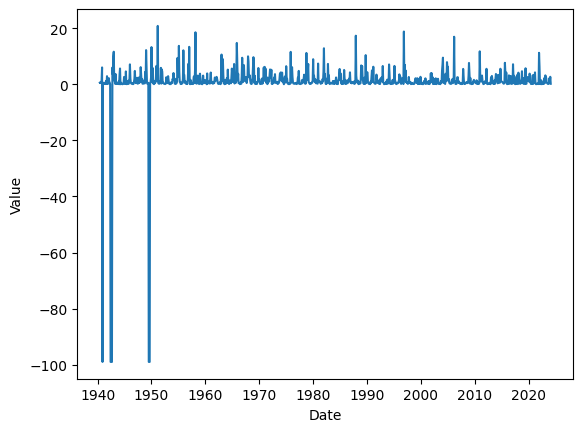

In [20]:
plt.plot(df['DateTime'], df['Value'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [21]:
### process missing values, linear interpolation
df['Value'] = df['Value'].replace(-99, np.nan)

In [22]:
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

df['Value'] = df['Value'].interpolate(method='linear')

In [23]:
timeseries = df['Value'].values.astype('float32')
timeseries

array([0.57, 0.69, 0.42, ..., 0.89, 2.65, 0.16], dtype=float32)

# 2.Convert the dataset and do the train-test split

In [24]:
import torch

### create dataset, X and y
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


In [25]:
n_len = 12
X, y = create_dataset(dataset = timeseries, lookback = n_len)

In [26]:
X.shape,y.shape

(torch.Size([993, 12]), torch.Size([993, 12]))

In [27]:
# train-test split
train_size = int(len(timeseries)*0.8)
test_size = len(timeseries) - train_size

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]



In [28]:
X_train.shape, X_test.shape, y_train.shape

(torch.Size([804, 12]), torch.Size([189, 12]), torch.Size([804, 12]))

# 3. TimeSeriesNN model

In [43]:
class TimeSeriesNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, batch_first=True, output_size = 1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature).
        self.batch_first = batch_first
        # see https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=batch_first)
        self.linear = nn.Linear(hidden_size*num_layers, output_size)

    def forward(self, x):
        # x: shape (N, L, D∗H_out)
        x, _ = self.lstm(x)
        # x: shape (N, L, output_size)
        x = self.linear(x)
        return x



In [47]:
model = TimeSeriesNN()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
loss_fn = nn.L1Loss()


train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
test_loader = data.DataLoader(data.TensorDataset(X_test, y_test), shuffle=False, batch_size=8)



In [48]:
for i, (X_batch, y_batch) in enumerate(train_loader):
    print(f"Batch {i + 1}")
    print("X_batch shape:", X_batch.shape)  # Shape of the features in the batch
    print("y_batch shape:", y_batch.shape)  # Shape of the labels in the batch

    # Optionally break the loop if you only want to check the first batch
    break

Batch 1
X_batch shape: torch.Size([8, 12])
y_batch shape: torch.Size([8, 12])


# 4.Train the TimeseriesNN model

In [52]:
def train(model, loader, loss_fn, optimizer):
    model.train()
    y_label_list = []
    y_pred_list = []
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.unsqueeze(-1))
        y_pred_list.append(y_pred)
        y_label_list.append(y_batch.unsqueeze(-1))
        loss = loss_fn(y_pred, y_batch.unsqueeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    y_label = torch.cat(y_label_list)
    y_pred = torch.cat(y_pred_list)
    mae = loss_fn(y_pred, y_label)
    #mae = np.sqrt(aloss.item())
    return loss, mae, y_pred, y_label


In [53]:
def test(model, loader, loss_fn):
    model.eval()
    with torch.no_grad():
        y_label_list = []
        y_pred_list = []
        for X_batch, y_batch in loader:
            y_pred_list.append(model(X_batch.unsqueeze(-1)))
            y_label_list.append(y_batch.unsqueeze(-1))

        y_label = torch.cat(y_label_list)
        y_pred = torch.cat(y_pred_list)
        loss = loss_fn(y_pred, y_label)
        mae = loss
        #mae = np.sqrt(loss.item())
        return loss, mae, y_pred, y_label

In [56]:
n_epochs = 100
for epoch in range(n_epochs):
    _, train_mae, _, _ = train(model, train_loader, loss_fn, optimizer)

    _, test_mae, y_testpred, y_testlabel = test(model, test_loader, loss_fn)


    print("Epoch %d: train mae %.4f, test mae %.4f" % (epoch, train_mae, test_mae))

Epoch 0: train mae 1.2823, test mae 1.0931
Epoch 1: train mae 1.2821, test mae 1.0933
Epoch 2: train mae 1.2817, test mae 1.0856
Epoch 3: train mae 1.2823, test mae 1.0931
Epoch 4: train mae 1.2816, test mae 1.0901
Epoch 5: train mae 1.2812, test mae 1.0927
Epoch 6: train mae 1.2811, test mae 1.0889
Epoch 7: train mae 1.2808, test mae 1.0906
Epoch 8: train mae 1.2809, test mae 1.0939
Epoch 9: train mae 1.2806, test mae 1.0978
Epoch 10: train mae 1.2807, test mae 1.0922
Epoch 11: train mae 1.2801, test mae 1.0953
Epoch 12: train mae 1.2802, test mae 1.0929
Epoch 13: train mae 1.2798, test mae 1.0914
Epoch 14: train mae 1.2797, test mae 1.0956
Epoch 15: train mae 1.2794, test mae 1.0913
Epoch 16: train mae 1.2792, test mae 1.0942
Epoch 17: train mae 1.2790, test mae 1.0938
Epoch 18: train mae 1.2787, test mae 1.0931
Epoch 19: train mae 1.2787, test mae 1.0940
Epoch 20: train mae 1.2785, test mae 1.0905
Epoch 21: train mae 1.2782, test mae 1.0931
Epoch 22: train mae 1.2777, test mae 1.086

# 5.Visualize the predicted time series together with the ground truth

In [87]:
# Plot ith time series in the test data, Predicted VS Ground Truth
import matplotlib.pyplot as plt
def plottimeseries(y_testlabel, y_testpred,i):
  plt.figure()
  plt.plot(y_testpred[i].tolist(), label='label', marker='o')
  plt.plot(y_testlabel[i].tolist(), label='prediction', marker='x')
  plt.title('Predicted VS Ground Truth')
  plt.xlabel('Index')
  plt.ylabel('Precipitation')



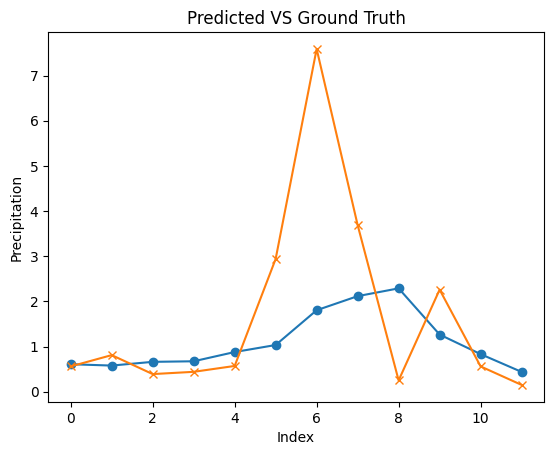

In [88]:
plottimeseries(y_testlabel,y_testpred,11)

In [81]:
#y_testpred, y_testlabel
y_testpred1 = y_testpred[1].tolist()
y_testlabel1 = y_testlabel[1].tolist()

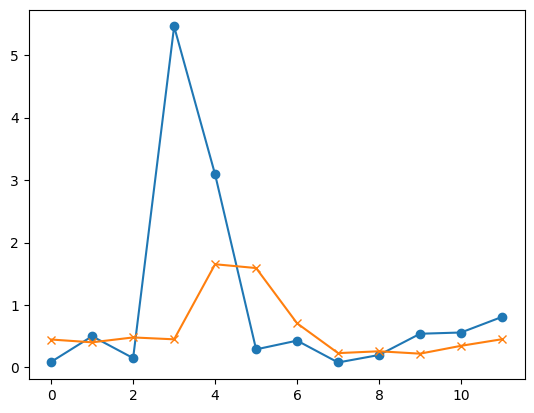

In [82]:
plt.figure()

plt.plot(y_testlabel1, label='label', marker='o')  # Adds markers to each data point
plt.plot(y_testpred1, label='prediction', marker='x')  # Adds markers to each data point